
# 1D forward modelling


In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

from simpeg import maps
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model

write_output = False
plt.rcParams.update({"font.size": 16})

# sphinx_gallery_thumbnail_number = 2

## Create Survey

A circular loop of area 100 m x100 m was assumed. 

radius= $\sqrt{}$(area/$\Pi$)= 56.4 m.







In [2]:
# Source properties
source_location = np.array([0.0, 0.0, 0.1]) # 0.1 m due to protem being on the ground
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current
source_radius = 56.4  # source loop radius (chosen from an area of 100x100)

# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.1])
receiver_orientation = "z"  # "x", "y" or "z"
times = np.logspace(-5, -2, 31)  # time channels (s)

# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple component and/or field orientations,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Define the source waveform. Here we define a unit step-off. The definition of
# other waveform types is covered in a separate tutorial.
waveform = tdem.sources.StepOffWaveform()

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

## Layers Parameters

Model consists of layers of ice, water, lake sediments, talik sediments, and permafrost.

Ice and water depths were obtained from Table 1 of Oldenborger (2024).

Ice resistivity is $10^3$-$10^5$ $\ohm.m$ from Oldenborger (2024) pp. 2 and water resistivity is 125 $\ohm.m$ also from Oldenborger (2024).

### Case 1: Talik separated by permafrost

Using site 2 of Oldenborger (2024) as an example for ice and water depths.

* Layer 1: Ice
* Layer 2: Water
* Layer 3: Lake sediments (part of the talik separated by permafrost; shallower conductive layer)
* Layer 4: Highly resistive upper permafrost
* Layer 5: Deeper conductive talik sediments
* Layer 6: Infinitely long highly resistive permafrost

Lake sediments resistivity= 85 (1-100) $\ohm.m$ from Oldenborger (2024) pp. 7

Upper permafrost resistivity= 20000 $\ohm.m$ from Oldenborger (2024) pp. 7

Deeper talik sediments resistivity= 50 (1-100) $\ohm.m$ Oldenborger (2024) pp. 7.

Infinite permafrost layer's resistivity= 20000 $\ohm.m$

### Case 2: Talik connected to groundwater system

Using site 2 of Oldenborger (2024) as an example for ice and water depths.

* Layer 1: Ice
* Layer 2: Water
* Layer 3: Lake sediments (part of the talik; shallower conductive layer)
* Layer 4: Deeper talik sediments connected to groundwater system

Resistivities of the layers are assumed to be the same as Case 1.


<Axes: xlabel='Conductivity S/m', ylabel='Depth (m)'>

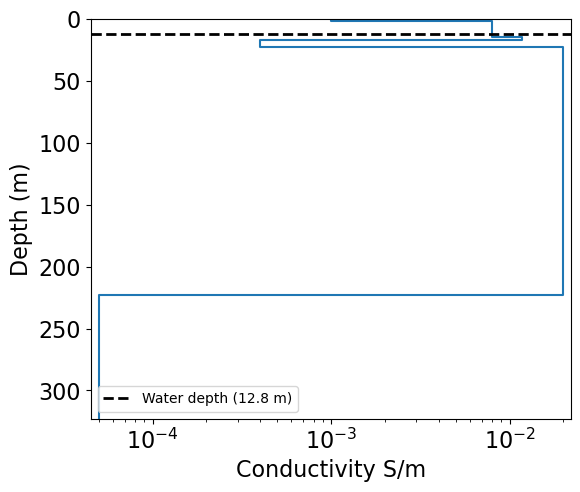

In [9]:
# Physical properties
#background_conductivity = 1e-1
#layer_conductivity = 1e0
ice_depth=1.8
water_depth=12.8
lake_seds_depth=3.0
talik_seds_depth=200

ice_res=1000
water_res=125
lake_seds_res=85
talik_seds_res=50
permafrost_res=20000


upper_permafrost_depth=5
upper_permafrost_res=2500
thicknesses = np.array([ice_depth, water_depth, lake_seds_depth,upper_permafrost_depth, talik_seds_depth]) # Talik separated by permafrost of thickness 5 m 
n_layer = len(thicknesses) + 1

# physical property models
#model = background_conductivity * np.ones(n_layer)
resistivities=np.array([ice_res,water_res,lake_seds_res,upper_permafrost_res,talik_seds_res,permafrost_res]) # Resistivity of permafrost separating talik 2500 ohm.m

'''
thicknesses = np.array([ice_depth, water_depth,lake_seds_depth]) # Talik connected to groundwater system (assuming no permafrost) 
n_layer = len(thicknesses) + 1

# physical property models
#model = background_conductivity * np.ones(n_layer)
resistivities=np.array([ice_res, water_res, lake_seds_res, talik_seds_res])
'''

conductivities=1.0/resistivities

model=conductivities
#model[1] = layer_conductivity

# Define a mapping for conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

# Plot conductivity model
thicknesses_for_plotting = np.r_[thicknesses, 100.0]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
plot_1d_layer_model(thicknesses_for_plotting, model, ax=ax, show_layers=False)
line=ax.axhline(water_depth, linestyle='--', color='k', linewidth=2, label='Water depth (12.8 m)')
plt.legend(fontsize=10)
ax.set_xlabel("Conductivity S/m")
plt.gca()

## Comparing background and target models

Background model: No talik. Just ice->water->permafrost.

Target model: ice->water->sediments->talik->permafrost.


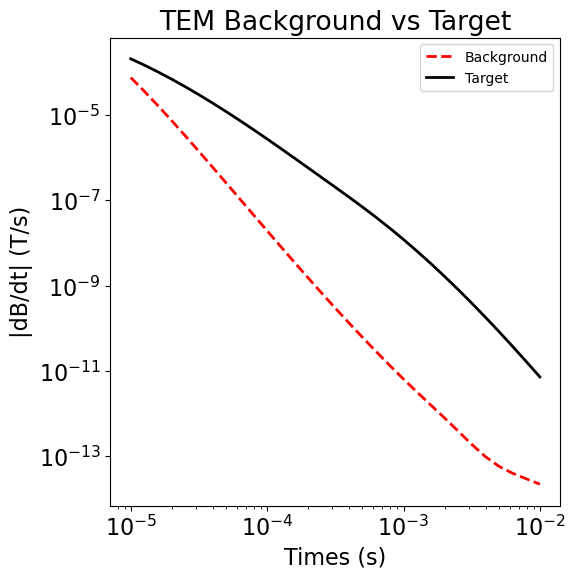

In [29]:
#Background model
backgrnd_thickness=np.array([ice_depth, water_depth])
backgrnd_res=np.array([ice_res, water_res, permafrost_res])
backgrnd_con=1.0/backgrnd_res

#Target model
target_thickness=np.array([ice_depth, water_depth, lake_seds_depth, talik_seds_depth])
target_res=np.array([ice_res, water_res, lake_seds_res, talik_seds_res, permafrost_res])
target_con=1.0/target_res

#Background simulation
sim_bg=tdem.Simulation1DLayered(survey=survey, thicknesses=backgrnd_thickness, sigmaMap=maps.IdentityMap(nP=len(backgrnd_con)))

#Target simulation
sim_tg=tdem.Simulation1DLayered(survey=survey, thicknesses=target_thickness, sigmaMap=maps.IdentityMap(nP=len(target_con)))

#Predicting dB/dt for background and target
dpred_bg=sim_bg.dpred(backgrnd_con)
dpred_tg=sim_tg.dpred(target_con)

# Plot sounding
fig= plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, np.abs(dpred_bg), "r--", lw=2, label='Background')
ax.loglog(times, np.abs(dpred_tg), "k-", lw=2, label='Target')
ax.set_xlabel("Times (s)")
ax.set_ylabel("|dB/dt| (T/s)")
ax.set_title("TEM Background vs Target")
plt.legend(fontsize=10)
                            

## Plotting the difference between background and target signals 

Basically to see how the talik affects the TEM decay 

Isolate the talik signal

Enhances SNR?

Earlier peak=> earlier time gates? Same thing for later peaks?

Used linear y-axis to see small changes 

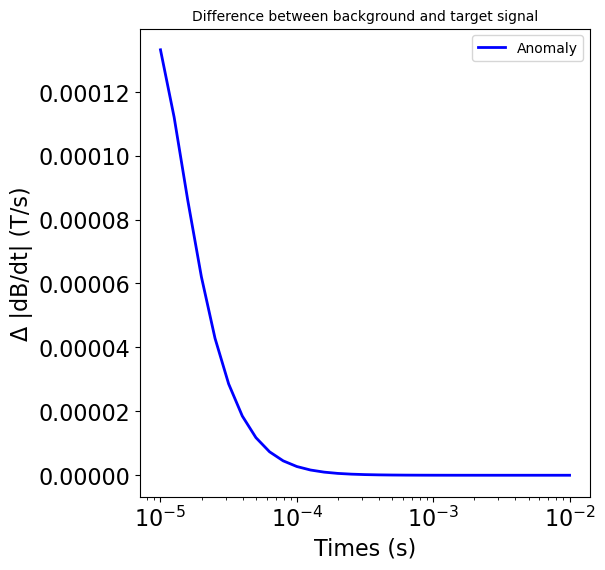

In [30]:
anomaly=dpred_bg-dpred_tg
fig= plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.semilogx(times, np.abs(anomaly), "b-", lw=2, label='Anomaly')
ax.set_xlabel("Times (s)")
ax.set_ylabel("\u0394 |dB/dt| (T/s)")
ax.set_title("Difference between background and target signal", fontsize=10)
plt.legend(fontsize=10)

## Define the Forward Simulation, Predict Data and Plot

Here we define the simulation and predict the 1D TDEM sounding data.
The simulation requires the user define the survey, the layer thicknesses
and a mapping from the model to the conductivities of the layers.

When using the *simpeg.electromagnetics.time_domain_1d* module,
predicted data are organized by source, then by receiver, then by time channel.




Text(0.5, 1.0, 'TEM dB/dt decay curve')

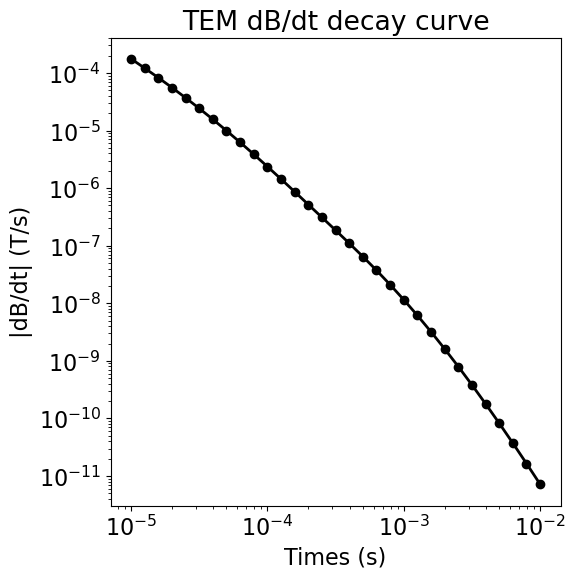

In [24]:
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping,
)

# Predict data for a given model
dpred = simulation.dpred(model)

# Plot sounding
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, np.abs(dpred), "k-o", lw=2)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|dB/dt| (T/s)")
ax.set_title("TEM dB/dt decay curve")

## Write Output (Optional)




In [5]:
if write_output:
    dir_path = os.path.dirname(__file__).split(os.path.sep)
    dir_path.extend(["outputs"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    np.random.seed(347)
    noise = 0.05 * np.abs(dpred) * np.random.randn(len(dpred))
    dpred += noise
    fname = dir_path + "em1dtm_data.txt"
    np.savetxt(fname, np.c_[times, dpred], fmt="%.4e", header="TIME BZ")